In [1]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda ,Layer
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pickle

In [3]:
from gensim.models import KeyedVectors

In [4]:
BASE_DIR = os.path.dirname(os.getcwd()) + '/input/'
EMBEDDING_FILE = BASE_DIR + 'GoogleNews-vectors-negative300.bin' #from kaggle
TRAIN_DATA_FILE = BASE_DIR + 'train.csv'


In [5]:
print(os.path.dirname(os.getcwd())) #path of input folder

c:\Users\14792\Desktop\search\NLP\Quora_project


In [6]:
print(BASE_DIR)

c:\Users\14792\Desktop\search\NLP\Quora_project/input/


In [7]:
train_df = pd.read_csv(TRAIN_DATA_FILE)
MAX_WORDS = 200000
MAX_SEQUENCE_LENGTH = 40
EMBEDDING_DIM = 300

In [8]:
print('Null values in train.csv')
print(train_df.isnull().sum())

Null values in train.csv
id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [9]:
print('Dropping null values')
train_df = train_df.dropna()

Dropping null values


In [10]:
print('Null values in train.csv')
print(train_df.isnull().sum())

Null values in train.csv
id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [11]:
import re
from bs4 import BeautifulSoup

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag #for part of speech
from nltk.corpus import wordnet

import os

# Set the NLTK data path to the directory where WordNet is located
nltk.data.path.append('lstmenv\nltk_data\corpora\wordnet')
nltk.data.path.append('lstmenv\nltk_data\corpora\stopwords')
nltk.data.path.append('lstmenv\nltk_data\taggers\averaged_perceptron_tagger_eng')

In [12]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
STOP_WORDS = stopwords.words("english")

In [13]:
def get_wordnet_pos(treebank_tag):
    """Map NLTK's POS tags to WordNet's POS tags for lemmatizer."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [14]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    
    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q, features="html.parser")
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    # Tokenize and remove stop words
    tokens = q.split()
    filtered_tokens = [word for word in tokens if word not in STOP_WORDS]

    # POS tagging and Lemmatization
    pos_tagged = pos_tag(filtered_tokens)
    q = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tagged])
    
    return q

In [15]:
print(STOP_WORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
train_df['question1'] = train_df['question1'].apply(preprocess)
train_df['question2'] = train_df['question2'].apply(preprocess)

C:\Users\14792\AppData\Local\Temp\ipykernel_30464\1255363441.py:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q, features="html.parser")


In [17]:
#for deep learing i will take 80% for training , 20% for valdiation then part 3 is testing (Take whole another dataset Test.csv)
train_size = int(len(train_df)* .8)
print("Train Size = %d" % train_size)
print("validation_size = %d" % (len(train_df)-train_size)) #take 20% of whole dataset
question1_train = train_df['question1'].values[:train_size]
question2_train = train_df['question2'].values[:train_size]
isDuplicate_train = train_df['is_duplicate'].values[:train_size]

Train Size = 323429
validation_size = 80858


In [18]:
question1_validate = train_df['question1'].values[train_size:]
question2_validate = train_df['question2'].values[train_size:]
isDuplicate_validate = train_df['is_duplicate'].values[train_size:]

In [19]:
print(question1_train[:5]) #take first 5 rows
print(question2_train[:5])

['step step guide invest share market india'
 'story kohinoor koh noor diamond'
 'increase speed internet connection use vpn' 'mentally lonely solve'
 'one dissolve water quikly sugar salt methane carbon di oxide']
['step step guide invest share market'
 'would happen indian government steal kohinoor koh noor diamond back'
 'internet speed increase hack dns'
 'find remainder 23 24 math divide 24 23' 'fish would survive salt water']


In [20]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(list(question1_train)+list(question2_train)+list(question1_validate)+list(question2_validate))

In [21]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 77533 unique tokens


In [22]:
print(word_index)

{'best': 1, 'get': 2, 'india': 3, 'good': 4, 'make': 5, 'like': 6, 'people': 7, 'use': 8, 'way': 9, 'would': 10, 'one': 11, 'quora': 12, 'learn': 13, 'time': 14, 'life': 15, 'know': 16, 'difference': 17, 'work': 18, 'year': 19, 'money': 20, 'go': 21, 'thing': 22, 'question': 23, 'find': 24, 'think': 25, 'new': 26, 'start': 27, 'indian': 28, 'much': 29, 'someone': 30, 'book': 31, 'mean': 32, 'become': 33, 'u': 34, 'many': 35, 'day': 36, 'take': 37, 'want': 38, 'job': 39, 'movie': 40, 'trump': 41, 'ever': 42, 'without': 43, 'world': 44, 'online': 45, 'first': 46, 'girl': 47, 'note': 48, 'love': 49, 'well': 50, 'feel': 51, '2': 52, 'company': 53, 'english': 54, 'could': 55, 'happen': 56, 'phone': 57, 'lose': 58, 'see': 59, '1': 60, '2016': 61, 'account': 62, 'buy': 63, 'need': 64, 'possible': 65, 'number': 66, 'country': 67, 'woman': 68, 'change': 69, 'old': 70, 'ask': 71, 'compare': 72, '500': 73, 'long': 74, '1k': 75, 'language': 76, 'person': 77, 'say': 78, 'student': 79, 'weight': 80,

In [23]:
word_counts = tokenizer.word_counts
print(word_counts)

OrderedDict([('step', 1537), ('guide', 394), ('invest', 2344), ('share', 2044), ('market', 2866), ('india', 29567), ('story', 2688), ('kohinoor', 20), ('koh', 22), ('noor', 9), ('diamond', 200), ('increase', 4856), ('speed', 2209), ('internet', 2620), ('connection', 564), ('use', 25385), ('vpn', 278), ('mentally', 278), ('lonely', 290), ('solve', 1935), ('one', 21703), ('dissolve', 95), ('water', 4037), ('quikly', 3), ('sugar', 452), ('salt', 443), ('methane', 35), ('carbon', 440), ('di', 33), ('oxide', 87), ('astrology', 340), ('capricorn', 44), ('sun', 1046), ('cap', 190), ('moon', 1267), ('rise', 554), ('say', 7078), ('buy', 7864), ('tiago', 4), ('good', 27802), ('geologist', 10), ('シ', 2), ('instead', 1981), ('し', 2), ('motorola', 75), ('company', 8654), ('hack', 3688), ('charter', 219), ('motorolla', 1), ('dcx3400', 2), ('method', 1495), ('find', 12615), ('separation', 132), ('slit', 290), ('fresnel', 4), ('biprism', 1), ('read', 4906), ('youtube', 3161), ('comment', 946), ('make'

In [24]:
sequences_1 = tokenizer.texts_to_sequences(question1_train)
sequences_2 = tokenizer.texts_to_sequences(question2_train)
validation_sequences_1= tokenizer.texts_to_sequences(question1_validate)
validation_sequences_2 = tokenizer.texts_to_sequences(question2_validate)

In [25]:
print(sequences_1[:5])

[[547, 547, 1836, 340, 405, 265, 3], [284, 11407, 10835, 17058, 3015], [134, 367, 289, 1398, 8, 2385], [2386, 2302, 433], [11, 4778, 170, 28656, 1665, 1695, 8480, 1702, 8750, 5056]]


In [26]:
data_1 = pad_sequences(sequences_1, maxlen=MAX_SEQUENCE_LENGTH) #add padding to make every sequences at asme lenght
data_2 = pad_sequences(sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(isDuplicate_train)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (323429, 40)
Shape of label tensor: (323429,)


In [27]:
print("Printing the padded sequence for question 1\n")
print(data_1)
print("\nPrinting the padded sequence for question 2\n")
print(data_2)

Printing the padded sequence for question 1

[[    0     0     0 ...   405   265     3]
 [    0     0     0 ... 10835 17058  3015]
 [    0     0     0 ...  1398     8  2385]
 ...
 [    0     0     0 ...    73    75    48]
 [    0     0     0 ...   127  1668  8920]
 [    0     0     0 ...   541    10     6]]

Printing the padded sequence for question 2

[[    0     0     0 ...   340   405   265]
 [    0     0     0 ... 17058  3015   140]
 [    0     0     0 ...   134   191  8610]
 ...
 [    0     0     0 ...    73    75    48]
 [    0     0     0 ...     0  1668  1668]
 [    0     0     0 ...   328   363     8]]


In [28]:
validation_data_1 = pad_sequences(validation_sequences_1, maxlen=MAX_SEQUENCE_LENGTH)
validation_data_2 = pad_sequences(validation_sequences_2, maxlen=MAX_SEQUENCE_LENGTH)
validation_labels = np.array(isDuplicate_validate)
print('Shape of data tensor:', validation_data_1.shape)
print('Shape of label tensor:', validation_labels.shape)

Shape of data tensor: (80858, 40)
Shape of label tensor: (80858,)


In [29]:
print("Printing the padded sequence for question 1\n")
print(validation_data_1)
print("\nPrinting the padded sequence for question 2\n")
print(validation_data_2)

Printing the padded sequence for question 1

[[    0     0     0 ...     0  1191  2610]
 [    0     0     0 ... 12658 12659   472]
 [    0     0     0 ...   121   816   153]
 ...
 [    0     0     0 ...     0    11  1644]
 [    0     0     0 ...  2788    28    79]
 [    0     0     0 ...     6   104  3373]]

Printing the padded sequence for question 2

[[    0     0     0 ...     0  1191  1000]
 [    0     0     0 ... 12658 12659   788]
 [    0     0     0 ...   915   664   153]
 ...
 [    0     0     0 ...     0     0  1644]
 [    0     0     0 ...  3551  3762  5304]
 [    0     0     0 ...     6   104  3373]]


In [30]:
#saving the created tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Tokenizer saved in tokenizer.pickle')

Tokenizer saved in tokenizer.pickle


# convert input words to vectors embedding by using word2vec

In [31]:
print('Indexing word vectors')

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.key_to_index))

Indexing word vectors
Found 3000000 word vectors of word2vec


In [32]:
# Print the first 10 words in the vocabulary
print(list(word2vec.key_to_index.keys())[:10])

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']


In [33]:
print(word2vec['king'])

[ 1.25976562e-01  2.97851562e-02  8.60595703e-03  1.39648438e-01
 -2.56347656e-02 -3.61328125e-02  1.11816406e-01 -1.98242188e-01
  5.12695312e-02  3.63281250e-01 -2.42187500e-01 -3.02734375e-01
 -1.77734375e-01 -2.49023438e-02 -1.67968750e-01 -1.69921875e-01
  3.46679688e-02  5.21850586e-03  4.63867188e-02  1.28906250e-01
  1.36718750e-01  1.12792969e-01  5.95703125e-02  1.36718750e-01
  1.01074219e-01 -1.76757812e-01 -2.51953125e-01  5.98144531e-02
  3.41796875e-01 -3.11279297e-02  1.04492188e-01  6.17675781e-02
  1.24511719e-01  4.00390625e-01 -3.22265625e-01  8.39843750e-02
  3.90625000e-02  5.85937500e-03  7.03125000e-02  1.72851562e-01
  1.38671875e-01 -2.31445312e-01  2.83203125e-01  1.42578125e-01
  3.41796875e-01 -2.39257812e-02 -1.09863281e-01  3.32031250e-02
 -5.46875000e-02  1.53198242e-02 -1.62109375e-01  1.58203125e-01
 -2.59765625e-01  2.01416016e-02 -1.63085938e-01  1.35803223e-03
 -1.44531250e-01 -5.68847656e-02  4.29687500e-02 -2.46582031e-02
  1.85546875e-01  4.47265

In [34]:
print(word2vec['king'].shape)

(300,)


In [35]:
print("Preparing embedding Matrix")
nb_words = min(MAX_WORDS, len(word_index))+1 # because the index start from zero
print("nb_words = %d" % nb_words)
#map word2vec to our model
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in tqdm(word_index.items()):
    if word in word2vec.key_to_index:
        embedding_matrix[i] = word2vec.get_vector(word) # Assign Word2Vec embedding, Retrieves the 300-dimensional vector for the word.

print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding Matrix
nb_words = 77534


100%|██████████| 77533/77533 [00:00<00:00, 450181.86it/s]


Null word embeddings: 37613


In [36]:
print(embedding_matrix[456]) # this specific word that has 456 index represent as 300 dim (embedding vector)

[-0.00585938  0.13183594  0.05297852 -0.15917969 -0.04125977 -0.22167969
 -0.16015625 -0.10498047 -0.08105469 -0.04736328  0.27539062 -0.33984375
  0.11083984 -0.34375    -0.20507812 -0.15625     0.13378906 -0.30859375
  0.14941406 -0.10400391  0.07373047  0.04223633  0.09326172  0.02783203
  0.00683594 -0.11962891 -0.1484375   0.28515625 -0.09033203 -0.20996094
 -0.03198242 -0.2578125  -0.06445312 -0.12451172  0.15039062 -0.12890625
 -0.07373047  0.12158203 -0.08056641 -0.07470703 -0.24902344 -0.14257812
  0.25976562 -0.1953125  -0.02392578  0.03662109 -0.19726562  0.16992188
 -0.05273438  0.01416016 -0.05395508 -0.28710938 -0.01434326 -0.07568359
 -0.03686523  0.19628906 -0.09912109 -0.06494141  0.02282715 -0.11767578
 -0.21679688 -0.10693359  0.14160156 -0.18164062  0.00588989 -0.20800781
  0.38476562  0.04321289  0.15039062  0.21191406  0.0267334   0.03466797
  0.24414062 -0.48046875 -0.17382812 -0.20898438  0.15722656 -0.08837891
  0.06176758 -0.14550781  0.20214844 -0.03442383 -0

In [37]:
class ExponentNegManhattanDistance(Layer):
    def call(self, inputs):
        left, right = inputs
        return K.exp(-K.sum(K.abs(left - right), axis=1, keepdims=True))

In [ ]:
########## Model Building ################
n_hidden = 50
batch_size = 64 
n_epoch = 30


# The visible layer (input layer)
left_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # Output Shape of left_input: (batch_size, max_sequence_length) i.e. (64, 40)
right_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # Output Shape of right_input: (batch_size, max_sequence_length)
# The embedding layer
embedding_layer = Embedding(
    len(embedding_matrix),
    EMBEDDING_DIM, 
    weights = [embedding_matrix], 
    trainable = False 
)
# Embedded version of the inputs
encoded_left = embedding_layer(left_input) #  (64, 40, 300)
encoded_right = embedding_layer(right_input) #  (64, 40, 300)


shared_lstm = LSTM(n_hidden) 
left_output = shared_lstm(encoded_left) # Output Shape: (batch_size, n_hidden) i.e. (64, 50)
# By default, the LSTM returns the output of the last hidden layer.
right_output = shared_lstm(encoded_right) # Output Shape: (batch_size, n_hidden) i.e. (64, 50)
# Calculates the distance as defined by the MaLSTM model
malstm_distance = ExponentNegManhattanDistance()([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance]) # finally, the output shape is (batch_size, 1) i.e. (64, 1) where 1 is output value from exponent_neg_manhattan_distance between 0 and 1.

In [39]:
malstm.compile(loss='binary_crossentropy', # binary_crossentropy is chosen as a loss function because it's suitable for the problems where the output is probability (between 0 and 1)
        optimizer='nadam', # adjusts the model weights to minimize the loss function
        metrics=['acc'])

In [40]:
# checkpoint for each iteration
filepath="data/weights-improvement-{epoch:02d}-{val_acc:.2f}.keras"

In [41]:
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint] # checkpoint just saves the weights after each epoch

malstm_trained = malstm.fit([data_1, data_2], labels, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([validation_data_1, validation_data_2], validation_labels),callbacks=callbacks_list)

Epoch 1/30


c:\Users\14792\Desktop\search\NLP\Quora_project\lstmenv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5052/5054 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.7276 - loss: 0.8275
Epoch 1: val_acc improved from -inf to 0.77416, saving model to data/weights-improvement-01-0.77.keras
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 138s 27ms/step - acc: 0.7276 - loss: 0.8275 - val_acc: 0.7742 - val_loss: 0.7854
Epoch 2/30
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.7797 - loss: 0.7568
Epoch 2: val_acc improved from 0.77416 to 0.78634, saving model to data/weights-improvement-02-0.79.keras
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 130s 26ms/step - acc: 0.7797 - loss: 0.7568 - val_acc: 0.7863 - val_loss: 0.7676
Epoch 3/30
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.7929 - loss: 0.7326
Epoch 3: val_acc improved from 0.78634 to 0.79481, saving model to data/weights-improvement-03-0.79.keras
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 150s 27ms/step - acc: 0.7929 - loss: 0.7326 - val_acc: 0.7948 - val_loss: 0.7571
Epoch 4/30
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.8018 - loss: 0.7226
Epoch 4: val_acc improve

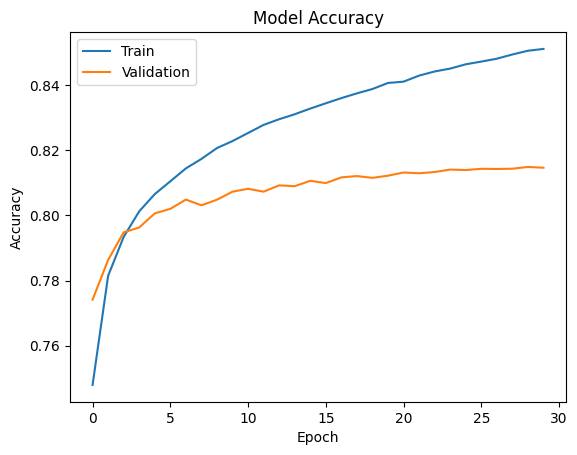

In [42]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

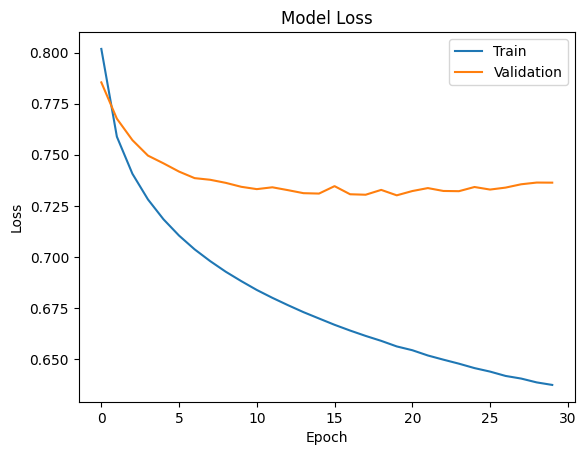

In [43]:
# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [44]:
# saving the entire model
malstm.save("malstm_saved_model.keras")